In [ ]:
! pip install -q kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d gti-upm/leapgestrecog
! unzip leapgestrecog.zip

Streaming output truncated to the last 5000 lines.
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0001.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0002.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0003.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0004.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0005.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0006.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0007.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0008.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0009.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0010.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0011.png  
  inflating: leapgestrecog/leapGestRecog/07/06_index/frame_07_06_0012.png  
  inflating: leapgestrecog/leapGestRe

In [ ]:
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image

from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from keras.models import Sequential
from keras.callbacks import EarlyStopping, ReduceLROnPlateau

In [ ]:
path = "./leapGestRecog"
folders = os.listdir(path)
inner_folders = os.listdir(path+"/01")
categories=[]
for i in inner_folders:
  category = i.split('_', maxsplit=1)[1:]
  categories.append(category[0])
num_classes = len(categories)
categories

['down',
 'index',
 'l',
 'palm_moved',
 'fist_moved',
 'fist',
 'thumb',
 'palm',
 'ok',
 'c']

In [ ]:
df = pd.DataFrame(columns=['filepaths','categories'])
paths , category = [], []
for folder in folders:
  inner_folders = os.listdir(path+'/'+folder)
  for inner_f in inner_folders:
    files = os.listdir(path+'/'+folder+"/"+inner_f)
    for file in files:
      paths.append(folder+'/'+inner_f+'/'+file)
      category.append(inner_f.split('_', maxsplit=1)[1])
df['filepaths'] = paths
df['categories'] = category

In [ ]:
im_size = (224, 224)
im_width, im_height = im_size
im_channels=1
batch_size = 50

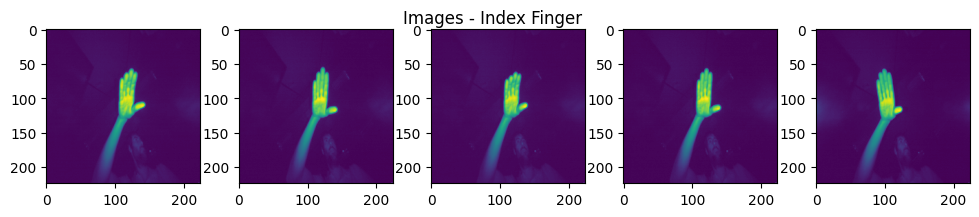

In [ ]:
fig = plt.figure(figsize=(12,2))
fig.suptitle("Images - Index Finger")

for i in range(5):
  img = Image.open(path+'/'+df['filepaths'][i])
  img = img.resize(im_size)
  plt.subplot(1, 5, i+1)
  plt.imshow(img)
  # print(img.shape)
plt.show()

In [ ]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=123)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=123)
train_df[:5]

,filepaths,categories
9642,02/07_ok/frame_02_07_0120.png,ok
17924,06/09_c/frame_06_09_0103.png,c
1642,03/07_ok/frame_03_07_0152.png,ok
9670,02/07_ok/frame_02_07_0054.png,ok
16860,06/04_fist_moved/frame_06_04_0019.png,fist_moved


In [ ]:
train_datagen = ImageDataGenerator(rescale=1/.255,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   rotation_range=40)

train_generator = train_datagen.flow_from_dataframe(
    train_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 16000 validated image filenames belonging to 10 classes.


In [ ]:
val_datagen = ImageDataGenerator(rescale=1/.255)
val_generator = val_datagen.flow_from_dataframe(
    val_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


## Model Definition

In [ ]:
model = Sequential([
    Conv2D(16, (3,3), activation='relu', input_shape=(im_size[0], im_size[1], 1)),
    MaxPooling2D((2,2)),
    Conv2D(32, (3,3), activation='relu'),
    MaxPooling2D((2,2)),
    Conv2D(64, (5,5), activation='relu'),
    MaxPooling2D((3,3)),
    Flatten(),
    Dense(1024, activation='relu'),
    Dropout(0.2),
    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dropout(0.2),
    Dense(num_classes, activation='softmax')
])
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['acc']
)

In [ ]:
earlystop = EarlyStopping(patience = 10)
learning_rate_reduction = ReduceLROnPlateau(monitor = 'val_acc', patience = 2, verbose = 1, factor = 0.5, min_lr = 0.00001)
callbacks = [earlystop, learning_rate_reduction]

## Model Training

In [ ]:
model_hist = model.fit(
    train_generator,
    validation_data = val_generator,
    steps_per_epoch=100,
    epochs=100,
    callbacks=callbacks
)

Epoch 1/100
100/100 [==============================] - 51s 368ms/step - loss: 3.5198 - acc: 0.1064 - val_loss: 2.2870 - val_acc: 0.1360 - lr: 0.0010
Epoch 2/100
100/100 [==============================] - 34s 344ms/step - loss: 2.2262 - acc: 0.1734 - val_loss: 2.0803 - val_acc: 0.2840 - lr: 0.0010
Epoch 3/100
100/100 [==============================] - 34s 345ms/step - loss: 2.0920 - acc: 0.2376 - val_loss: 1.8106 - val_acc: 0.3745 - lr: 0.0010
Epoch 4/100
100/100 [==============================] - 33s 333ms/step - loss: 2.0149 - acc: 0.2612 - val_loss: 1.6729 - val_acc: 0.3610 - lr: 0.0010
Epoch 5/100
100/100 [==============================] - 34s 344ms/step - loss: 1.9254 - acc: 0.2868 - val_loss: 1.6853 - val_acc: 0.4265 - lr: 0.0010
Epoch 6/100
100/100 [==============================] - 34s 337ms/step - loss: 1.7967 - acc: 0.3434 - val_loss: 1.4980 - val_acc: 0.4845 - lr: 0.0010
Epoch 7/100
100/100 [==============================] - 33s 326ms/step - loss: 1.6873 - acc: 0.3858 - val_l

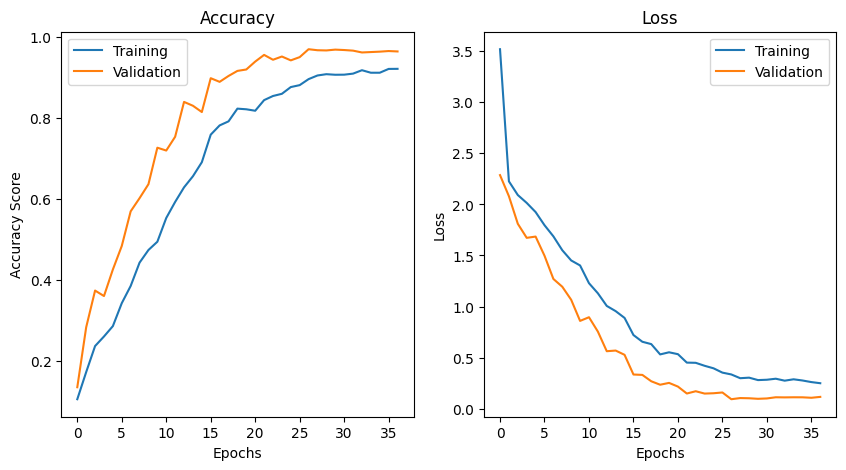

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1,2,1)
plt.plot(model_hist.history['acc'], label='Training')
plt.plot(model_hist.history['val_acc'], label='Validation')
plt.title("Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy Score")
plt.legend()

plt.subplot(1,2,2)
plt.plot(model_hist.history['loss'], label='Training')
plt.plot(model_hist.history['val_loss'], label='Validation')
plt.title("Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

plt.savefig("Training History.jpg")
plt.show()

In [ ]:
model.save('hand_gesture_recognition.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## Evaluation

In [ ]:
basic_test_generator = train_datagen.flow_from_dataframe(
    test_df,
    path+'/',
    x_col='filepaths',
    y_col='categories',
    target_size = im_size,
    class_mode='categorical',
    color_mode='grayscale',
    batch_size=batch_size,
    classes=categories
)

Found 2000 validated image filenames belonging to 10 classes.


In [ ]:
loss, acc = model.evaluate(basic_test_generator)
print("Testing Loss:", loss)
print("Testing Accuracy:", acc)

40/40 [==============================] - 11s 278ms/step - loss: 0.1615 - acc: 0.9475
Testing Loss: 0.16145505011081696
Testing Accuracy: 0.9474999904632568


## Inference

In [ ]:
from PIL import Image

In [ ]:
test_df[40:48]

,filepaths,categories
4662,05/08_palm_moved/frame_05_08_0159.png,palm_moved
13352,04/05_thumb/frame_04_05_0033.png,thumb
13647,04/07_ok/frame_04_07_0080.png,ok
5615,05/07_ok/frame_05_07_0026.png,ok
17957,06/09_c/frame_06_09_0112.png,c
15652,07/07_ok/frame_07_07_0102.png,ok
9179,02/03_fist/frame_02_03_0071.png,fist
5668,05/07_ok/frame_05_07_0006.png,ok


In [ ]:
sample_imgs=[]
for img_paths in test_df[100:108]['filepaths']:
  img = Image.open(path+'/'+img_paths)
  img = img.resize(im_size)
  img = img.convert('L')
  img = np.array(img)
  img = img.reshape((img.shape[0], img.shape[1], 1))
  sample_imgs.append(img)
sample_imgs = np.array(sample_imgs)
sample_imgs.shape

(8, 224, 224, 1)

In [ ]:
preds = model.predict(sample_imgs)
preds = np.argmax(preds, axis=1)

1/1 [==============================] - 0s 361ms/step


In [ ]:
preds

array([3, 7, 3, 8, 0, 9, 7, 4])

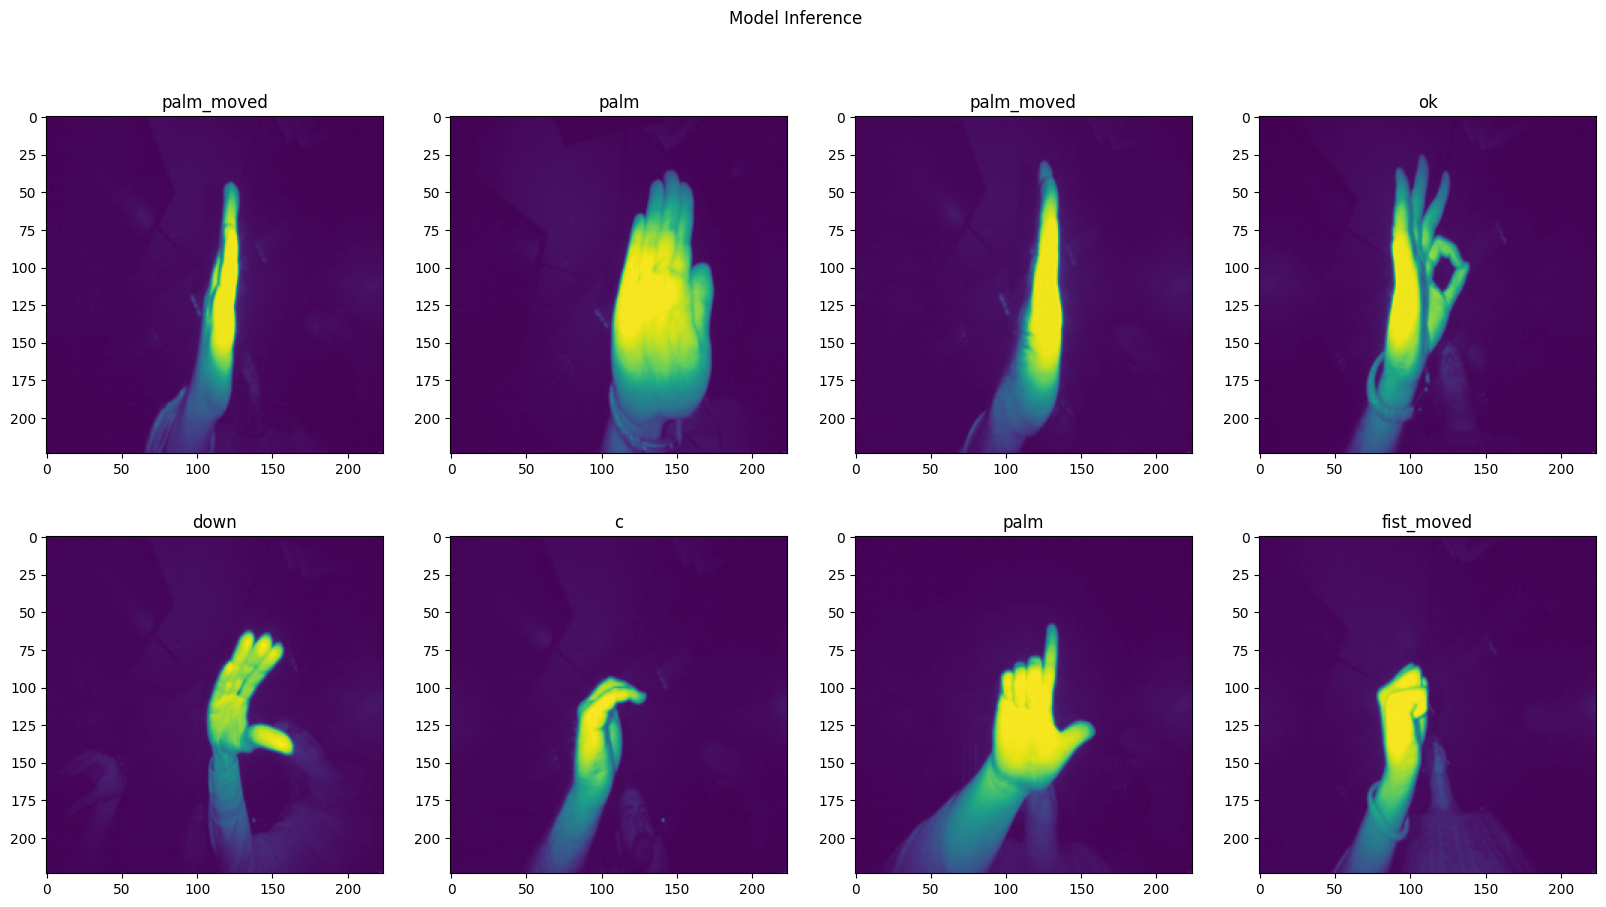

In [ ]:
fig = plt.figure(figsize=(20, 10))
fig.suptitle("Model Inference")
ind=1
for img in sample_imgs:
  plt.subplot(2,4,ind)
  plt.imshow(img)
  plt.title(categories[preds[ind-1]])
  ind+=1
plt.savefig("Hand Gesture model Inference.jpg")
plt.show()